In [40]:
#imports
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [41]:
os.path.abspath(os.getcwd())

df_standards_warm = pd.read_csv("../data/standards_warm/Data_28_5__15_41_20_0_zu_2500.csv")  
df_warm_standards = pd.read_csv("../data/warm_standards_hamilton/Data_9_6__16_12_35_0_zu_2500.csv")

#todo ask what is valueRAW and what is value? my guess is that its the same data but just scaled somehow (see plot)


In [42]:
df_warm_standards.head

<bound method NDFrame.head of      Unnamed: 0.1  Unnamed: 0                     Time  ValueRAW       Value  \
0               0           0  2021-06-09 16:03:42.933     32347  1010.84375   
1               1           1  2021-06-09 16:03:43.456     32196  1006.12500   
2               2           2  2021-06-09 16:03:43.981     32167  1005.21875   
3               3           3  2021-06-09 16:03:44.505     32079  1002.46875   
4               4           4  2021-06-09 16:03:45.030     32075  1002.34375   
..            ...         ...                      ...       ...         ...   
995           995         995  2021-06-09 16:12:32.765     22073   689.78125   
996           996         996  2021-06-09 16:12:33.292     22067   689.59375   
997           997         997  2021-06-09 16:12:33.844     22067   689.59375   
998           998         998  2021-06-09 16:12:34.370     22073   689.78125   
999           999         999  2021-06-09 16:12:34.910     22074   689.81250   

     Real

In [43]:
df_standards_warm.head

<bound method NDFrame.head of      Unnamed: 0.1  Unnamed: 0                     Time  ValueRAW       Value  \
0               0           0  2021-05-28 15:32:29.972     32520  1016.25000   
1               1           1  2021-05-28 15:32:30.493     32335  1010.46875   
2               2           2  2021-05-28 15:32:31.029     32272  1008.50000   
3               3           3  2021-05-28 15:32:31.563     32259  1008.09375   
4               4           4  2021-05-28 15:32:32.085     32251  1007.84375   
..            ...         ...                      ...       ...         ...   
995           995         995  2021-05-28 15:41:17.913     23466   733.31250   
996           996         996  2021-05-28 15:41:18.438     23456   733.00000   
997           997         997  2021-05-28 15:41:18.978     23467   733.34375   
998           998         998  2021-05-28 15:41:19.503     23444   732.62500   
999           999         999  2021-05-28 15:41:20.029     23451   732.84375   

     Real

In [44]:
time = df_standards_warm["Time"]
values = df_standards_warm["Value"]
values_raw = df_standards_warm["ValueRAW"]

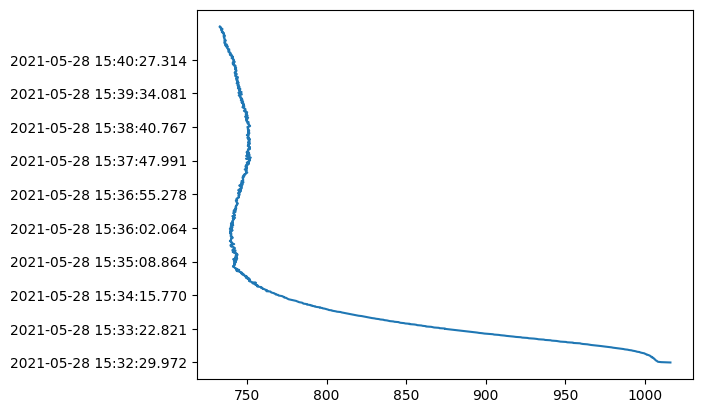

In [45]:
#plot time to values
plt.plot(values,time)
plt.yticks(range(0, len(time), 100))
plt.show()

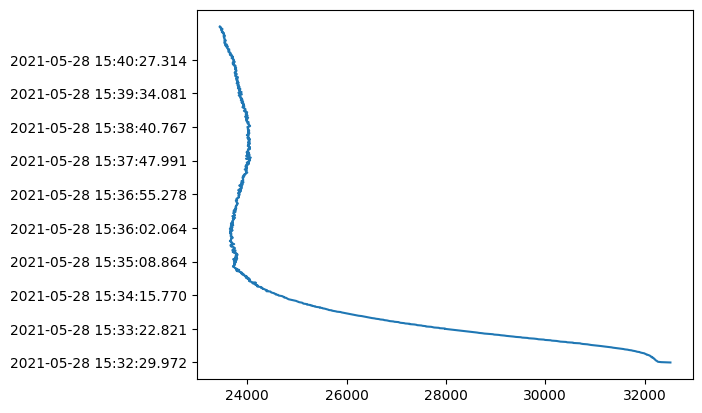

In [46]:
#plot time to valuesRAW

plt.plot(values_raw,time)
plt.yticks(range(0, len(time), 100))
plt.show()

In [47]:
#get data

with open("../data/data_max/value_target.csv", "w") as f:
    f.write("")

with open("../data/data_max/value_target.csv", "a") as f:
    header = "target"
    for i in range(1, 1001):
        header = header + ",value_" + str(i)
    f.write(header + "\n")

#iter over every file from a folder
for filename in os.listdir("../data/standards_warm/"):
    #open file
    df_standards_warm = pd.read_csv("../data/standards_warm/"+filename)  
    #get the number which appears at the end between _...csv
    number = filename.split("_")[-1].split(".")[0]
    #get the values from the column value
    values = df_standards_warm["Value"]
    #create a new file with the name data_max/file
    with open("../data/data_max/value_target.csv", "a") as f:
        #write the number which appears at the end between _...csv in a row of data/data_max/file
        f.write(number)
        #write a comma
        f.write(",")
        #write the values from the column value in a row of data/data_max/file
        f.write(",".join(str(x) for x in values))
        #write a new line
        f.write("\n")
        
#iter over every file from a folder
for filename in os.listdir("../data/warm_standards_hamilton"):
    #open file
    df_standards_warm = pd.read_csv("../data/warm_standards_hamilton/"+filename)  
    #get the number which appears at the end between _...csv
    number = filename.split("_")[-1].split(".")[0]
    #get the values from the column value
    values = df_standards_warm["Value"]
    #create a new file with the name data_max/file
    with open("../data/data_max/value_target.csv", "a") as f:
        #write the number which appears at the end between _...csv in a row of data/data_max/file
        f.write(number)
        #write a comma
        f.write(",")
        #write the values from the column value in a row of data/data_max/file
        f.write(",".join(str(x) for x in values))
        #write a new line
        f.write("\n")

In [48]:
df_value_target = pd.read_csv("../data/data_max/value_target.csv")

test = df_value_target.tail(3)

train = df_value_target.drop(df_value_target.tail(3).index)

test_x = test.drop("target", axis=1)

test_y = test["target"]

train_x = train.drop("target", axis=1)

train_y = train["target"]

#later for creating onnx file necessary
input_names = list(train_x)
output_names = list(train_y)

# Regression

In [49]:
train_x = pd.DataFrame(train_x)
train_y = pd.DataFrame(train_y)
test_x = pd.DataFrame(test_x)
test_y = pd.DataFrame(test_y)

scalerX = StandardScaler().fit(train_x)
scalerY = StandardScaler().fit(train_y)
train_x = scalerX.transform(train_x)
train_y = scalerY.transform(train_y)
test_x = scalerX.transform(test_x)
test_y = scalerY.transform(test_y)

model = LinearRegression().fit(train_x, train_y)

predictions = model.predict(test_x)

#print(predictions)
print(test_y)
#convert tensor to numpy
test_y = np.array(test_y)

#calculate MAE 
mae = sum(abs(predictions - test_y))/len(predictions)
print(mae)

[[-0.57659812]
 [ 0.40415756]
 [ 2.50577689]]
[1.18856419]


# Simple Neural Network

In [50]:
test_x = pd.DataFrame(test_x)
test_y = pd.DataFrame(test_y)
train_x = pd.DataFrame(train_x)
train_y = pd.DataFrame(train_y)

#convert data to tensors
test_x = torch.tensor(test_x.to_numpy()).float()
test_y = torch.tensor(test_y.to_numpy()).float()
train_x = torch.tensor(train_x.to_numpy()).float()
train_y = torch.tensor(train_y.to_numpy()).float()

#create a simple neural network with pytroch
model = torch.nn.Sequential(
    nn.Linear(1000, 100), 
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.ReLU(),
    nn.Linear(10, 1)
)

criterion = torch.nn.MSELoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

for epoch in range(1000):
    y_pred = model(train_x)
    loss = criterion(y_pred, train_y.float())
    print("epoch: ", epoch, "loss: ", loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
#cacluate predictions
pred_y = model(test_x.float())

#calculate MAE
mae = sum(abs(pred_y - test_y))/len(pred_y)
#convert tensor to array 
mae = mae.detach().numpy()
print("MAE: " + str(mae[0]))

#rescale data
pred_y = scalerY.inverse_transform(pred_y.detach().numpy())
test_y = scalerY.inverse_transform(test_y.detach().numpy())

#print(pred_y)
#print(test_y)



epoch:  0 loss:  0.9139732718467712
epoch:  1 loss:  26.79777717590332
epoch:  2 loss:  16.87739372253418
epoch:  3 loss:  2.412137746810913
epoch:  4 loss:  3.3571760654449463
epoch:  5 loss:  0.5948505401611328
epoch:  6 loss:  2.5175907611846924
epoch:  7 loss:  0.7507559657096863
epoch:  8 loss:  1.114174246788025
epoch:  9 loss:  1.8433743715286255
epoch:  10 loss:  0.3663758337497711
epoch:  11 loss:  1.2088979482650757
epoch:  12 loss:  1.1304681301116943
epoch:  13 loss:  0.24295851588249207
epoch:  14 loss:  1.1175910234451294
epoch:  15 loss:  0.6925863027572632
epoch:  16 loss:  0.23848827183246613
epoch:  17 loss:  0.922046959400177
epoch:  18 loss:  0.3882266879081726
epoch:  19 loss:  0.27288663387298584
epoch:  20 loss:  0.7182642221450806
epoch:  21 loss:  0.208403080701828
epoch:  22 loss:  0.30860039591789246
epoch:  23 loss:  0.49823296070098877
epoch:  24 loss:  0.13710452616214752
epoch:  25 loss:  0.2871994972229004
epoch:  26 loss:  0.3465648591518402
epoch:  27 

# Cross validation simple neural network

In [51]:
def scaler(train_x, train_y, test_x, test_y):
    """Scale data to standardization

    
    Returns:
        df: scaled data
    """
    test_x = pd.DataFrame(test_x)
    test_y = pd.DataFrame(test_y)
    train_x = pd.DataFrame(train_x)
    train_y = pd.DataFrame(train_y)
    
    scalerX = StandardScaler().fit(train_x)
    scalerY = StandardScaler().fit(train_y)
    train_x = scalerX.transform(train_x)
    train_y = scalerY.transform(train_y)
    test_x = scalerX.transform(test_x)
    test_y = scalerY.transform(test_y)
    
    test_x = pd.DataFrame(test_x)
    test_y = pd.DataFrame(test_y)
    train_x = pd.DataFrame(train_x)
    train_y = pd.DataFrame(train_y)

    test_x = torch.tensor(test_x.to_numpy()).float()
    test_y = torch.tensor(test_y.to_numpy()).float()
    train_x = torch.tensor(train_x.to_numpy()).float()
    train_y = torch.tensor(train_y.to_numpy()).float()
    
    return train_x, train_y, test_x, test_y
    
def model_standard(train_x, train_y, test_x, test_y):
    """ML modell for glucose prediction

    

    Returns:
        int: mae of the model trained with data split based on cross validation
    """
    train_x, train_y, test_x, test_y = scaler(train_x, train_y, test_x, test_y)
    
    model = torch.nn.Sequential(
    nn.Linear(1000, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.ReLU(),
    nn.Linear(10, 1)
    )

    criterion = torch.nn.MSELoss()

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

    for epoch in range(1000):
        y_pred = model(train_x)
        loss = criterion(y_pred, train_y.float())
        #print("epoch: ", epoch, "loss: ", loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    pred_y = model(test_x.float())
    mae = sum(abs(pred_y - test_y))/len(pred_y)
    mae = str(mae.detach().numpy()[0])
    return mae
    

def data_split(data, iteration_split, number_splits, check_for_last_iteration):
    """Splits data into train and test data.

    Args:
        data (df): df with all the data
        iteration_split (int): current batch step of cross validation
        number_splits ([type]): number of batches
        check_for_last_iteration (boolean): check if it is the last batch

    Returns:
        df: train and test data
    """
    if check_for_last_iteration == True:
        test = data.iloc[iteration_split * number_splits:]
        train = data.drop(data.iloc[iteration_split * number_splits:].index)
    else:
        test = data.iloc[iteration_split * number_splits : (iteration_split * number_splits + number_splits)]
        train = data.drop(data.iloc[iteration_split * number_splits : (iteration_split * number_splits + number_splits)].index)    
    
    test_x = test.drop("target", axis=1)

    test_y = test["target"]

    train_x = train.drop("target", axis=1)

    train_y = train["target"]
    
    return train_x, train_y, test_x, test_y

def cross_validation(model, data, number_splits):
    list_mae = []
    len_data = len(data)
    splits = len_data / number_splits
    split = int(splits)
    for i in range(number_splits):
        check_for_last_iteration = False
        if i == number_splits - 1:
            check_for_last_iteration = True
        train_x, train_y, test_x, test_y = data_split(data, i, split, check_for_last_iteration)
        model_result = model_standard(train_x, train_y, test_x, test_y)
        list_mae.append(model_result)
    print(list_mae)

cross_validation_result = cross_validation(model, df_value_target,5)
    

['0.6085335', '0.38842317', '0.11845733', '0.4491054', '0.21243374']


# Backtesting

In [61]:

#todo ask christoph if my understanding of backtesting was right. share code with him.

def scaler(train_x, train_y, test_x, test_y):
    """Scale data to standardization

    Returns:
        df: scaled data
    """
    test_x = pd.DataFrame(test_x)
    test_y = pd.DataFrame(test_y)
    train_x = pd.DataFrame(train_x)
    train_y = pd.DataFrame(train_y)
    
    scalerX = StandardScaler().fit(train_x)
    scalerY = StandardScaler().fit(train_y)
    train_x = scalerX.transform(train_x)
    train_y = scalerY.transform(train_y)
    test_x = scalerX.transform(test_x)
    test_y = scalerY.transform(test_y)
    
    test_x = pd.DataFrame(test_x)
    test_y = pd.DataFrame(test_y)
    train_x = pd.DataFrame(train_x)
    train_y = pd.DataFrame(train_y)

    test_x = torch.tensor(test_x.to_numpy()).float()
    test_y = torch.tensor(test_y.to_numpy()).float()
    train_x = torch.tensor(train_x.to_numpy()).float()
    train_y = torch.tensor(train_y.to_numpy()).float()
    
    return train_x, train_y, test_x, test_y

def model_standard(train_x, train_y, test_x, test_y):
    """ML modell for glucose prediction

    Returns:
        int: mae of the model trained with data split based on cross validation
    """
    #print(train_x.shape[1])
    #first itertionits 100 than 0
    input_size_layer_one = train_x.shape[1]
    output_size_layer_one = int(train_x.shape[1] / 10)
    input_size_layer_two = output_size_layer_one
    output_size_layer_two = int(output_size_layer_one / 10)
    input_size_layer_three = output_size_layer_two
    output_size_layer_three = int(input_size_layer_three / input_size_layer_three)

    model = torch.nn.Sequential(    
        nn.Linear(input_size_layer_one, output_size_layer_one),
        nn.ReLU(),
        nn.Linear(input_size_layer_two, output_size_layer_two),
        nn.ReLU(),
        nn.Linear(input_size_layer_three, output_size_layer_three)
    )

    criterion = torch.nn.MSELoss()

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

    for epoch in range(1000):
        y_pred = model(train_x)
        loss = criterion(y_pred, train_y.float())
        #print("epoch: ", epoch, "loss: ", loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    pred_y = model(test_x.float())
    mae = sum(abs(pred_y - test_y))/len(pred_y)
    mae = str(mae.detach().numpy()[0])
    return mae 

def split_data():
    df_value_target = pd.read_csv("../data/data_max/value_target.csv")
    test = df_value_target.tail(5)
    train = df_value_target.drop(df_value_target.tail(5).index)
    test_x = test.drop("target", axis=1)
    test_y = test["target"]
    train_x = train.drop("target", axis=1)
    train_y = train["target"]
    return train_x, train_y, test_x, test_y
    

def backtesting(train_x, train_y, test_x, test_y, number_splits):
    train_x, train_y, test_x, test_y = scaler(train_x, train_y, test_x, test_y)
    #divide len X by number splits if there is rest than count rest as additional split 
    split_batch = int(len(train_x[0]) / number_splits)
    #make a list for the mae and start with inputting into standard model the first splits  
    list_mae = []
    counter = 0
    #forward backtesting
    for i in range(number_splits):
        counter = counter + split_batch
        train_x_new = train_x[:, :counter]
        test_x_new = test_x[:, :counter]
        mae = model_standard(train_x, train_y, test_x, test_y)
        list_mae.append(mae)

    counter = train_x.shape[1]
    #reverse
    for i in range(number_splits):
        #take  
        counter = counter - split_batch
        train_x_new = train_x[:, counter:]
        test_x_new = test_x[:, counter:]
        mae = model_standard(train_x, train_y, test_x, test_y)
        list_mae.append(mae)
            
    return list_mae
    #if its the last split take rest 
    #backwards
    #return list with mae 

train_x, train_y, test_x, test_y = split_data()
#need to get the data from somewhere
backtesting_result = backtesting(train_x, train_y, test_x, test_y, number_splits=10)
print(backtesting_result)
    


['0.390934', '0.22877565', '0.20037165', '0.12818208', '0.19962206', '0.5172371', '0.27607256', '0.22886796', '0.41130614', '0.28276262', '0.21227905', '0.5292761', '0.51915056', '0.2634031', '0.36204642', '0.12399466', '0.45943752', '0.19186418', '0.5806263', '0.26161772']


# Netron architecture visualization

In [ ]:
'''#visualize model structure with netron
model.eval()
input_names = ['Values']
output_names = ['Targets']

torch.onnx.export(model,
                  train_x, 
                  "../model_structure/simple_nn.onnx", 
                  input_names=input_names, 
                  output_names=output_names,
                  )    '''

'#visualize model structure with netron\nmodel.eval()\ninput_names = [\'Values\']\noutput_names = [\'Targets\']\n\ntorch.onnx.export(model,\n                  train_x, \n                  "../model_structure/simple_nn.onnx", \n                  input_names=input_names, \n                  output_names=output_names,\n                  )    '

# AutoML 

## h2o

In [ ]:
'''import h2o
from h2o.automl import H2OAutoML

h2o.init()

train = h2o.import_file("../data/data_max/train.csv")
test = h2o.import_file("../data/data_max/test.csv")

x = train.columns
y = "target"
x.remove(y)

train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=x, y=y, training_frame=train)

lb = aml.leaderboard
lb.head(rows=lb.nrows)

aml.leader'''

'import h2o\nfrom h2o.automl import H2OAutoML\n\nh2o.init()\n\ntrain = h2o.import_file("../data/data_max/train.csv")\ntest = h2o.import_file("../data/data_max/test.csv")\n\nx = train.columns\ny = "target"\nx.remove(y)\n\ntrain[y] = train[y].asfactor()\ntest[y] = test[y].asfactor()\n\naml = H2OAutoML(max_models=20, seed=1)\naml.train(x=x, y=y, training_frame=train)\n\nlb = aml.leaderboard\nlb.head(rows=lb.nrows)\n\naml.leader'

In [ ]:
#print(lb)

In [ ]:
'''m = h2o.get_model("DeepLearning_grid_2_AutoML_1_20221029_144215_model_2")
print(m)'''

'm = h2o.get_model("DeepLearning_grid_2_AutoML_1_20221029_144215_model_2")\nprint(m)'

In [ ]:
#uninstall glucose venv -
#create glucose venv - 
#install pyton 3.11 with brew and try to get h2o running 
#create venv in brew python - 
#check packages --> needs to be empty - 
#run first cell of this notebook - 
#install required python - 
#install numpy and import numpy in a cell and check if i dont get an error - 
#install h20 
#run a demo succesfully

#create virtual env in commandline
#activate virtual env